In [1]:
import polars as pl
import plotly.express as px
import pyarrow

In [6]:
total_genome_length = 1148597545

In [2]:
# We only want the "RG" lines for ROH from bcftools

!grep "^RG" ../CircosPlot/bcftoolsroh > roh_data

In [3]:
data = pl.read_csv("roh_data", comment_char = "#", separator = "\t", has_header=False, new_columns = ["Type", "Sample", "Chr", "Start", "End", "Length", "NumMarkers", "Quality"])
data.head()

Type,Sample,Chr,Start,End,Length,NumMarkers,Quality
str,str,str,i64,i64,i64,i64,f64
"""RG""","""Adelaide""","""S1""",715348,789971,74624,261,61.9
"""RG""","""Adelaide""","""S1""",967118,1001915,34798,147,12.8
"""RG""","""Adelaide""","""S1""",1228034,1240431,12398,104,29.6
"""RG""","""Adelaide""","""S1""",1316518,1347128,30611,126,53.1
"""RG""","""Adelaide""","""S1""",2251310,2304273,52964,234,57.8


In [4]:
founders = pl.read_csv("../CircosPlot/founder_names", has_header=False, new_columns=["ID"])
offspring = pl.read_csv("../CircosPlot/offspring_names", has_header=False, new_columns=["ID"])
founders = list(founders["ID"])
offspring = list(offspring["ID"])
#founders

In [9]:
data = data.with_columns([
    (pl.col("Sample").is_in(founders)).alias("Founder")
])

#founders_data = data.filter(pl.col("Sample").is_in(founders))
#offspring_data = data.filter(pl.col("Sample").is_in(offspring))
#founders_data.head()
data

Type,Sample,Chr,Start,End,Length,NumMarkers,Quality,Founder
str,str,str,i64,i64,i64,i64,f64,bool
"""RG""","""Adelaide""","""S1""",715348,789971,74624,261,61.9,false
"""RG""","""Adelaide""","""S1""",967118,1001915,34798,147,12.8,false
"""RG""","""Adelaide""","""S1""",1228034,1240431,12398,104,29.6,false
"""RG""","""Adelaide""","""S1""",1316518,1347128,30611,126,53.1,false
"""RG""","""Adelaide""","""S1""",2251310,2304273,52964,234,57.8,false
"""RG""","""Adelaide""","""S1""",2548361,2724203,175843,450,26.3,false
"""RG""","""Adelaide""","""S1""",3510914,3905758,394845,1244,87.0,false
"""RG""","""Adelaide""","""S1""",4145398,4284244,138847,445,51.1,false
"""RG""","""Adelaide""","""S1""",4315410,4319257,3848,42,21.5,false


In [20]:
data_agg = data.groupby("Sample").agg([pl.sum("Length")/total_genome_length, pl.count(), pl.first("Founder")])
data_agg.head()

Sample,Length,count,Founder
str,f64,u32,bool
"""Hine_Taumai""",0.023182,101,false
"""Hurihuri""",0.062851,87,false
"""Pura""",0.054258,92,false
"""Hoki""",0.057249,104,false
"""Maggie""",0.038229,147,true


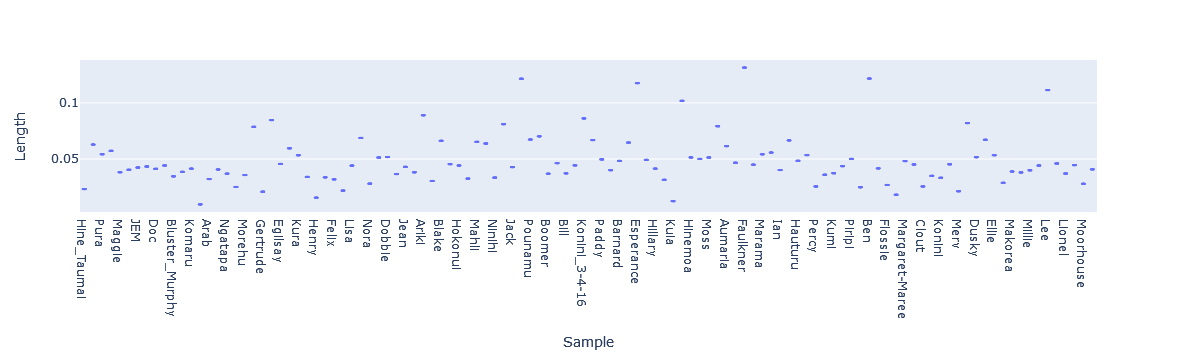

In [22]:
px.box(data_agg.to_pandas(), x="Sample", y="Length")